In [2]:
# Import libraries
import pandas as pd
#from data_processing import topic_modeling_on_assay_descriptions_w_lda, topic_modeling_on_assay_descriptions_w_bert

In [27]:
processed_data = pd.read_csv("processed_data_w_assay_celltype.csv")
descriptions = processed_data.description.to_list()

In [28]:
import re

# Remove punctuation
processed_data['descriptions_processed'] = \
processed_data['description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
processed_data['descriptions_processed'] = \
processed_data['descriptions_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
processed_data['descriptions_processed'].head()

0    in vitro anticancer activity against 2 nci scl...
1    in vitro anticancer activity against 2 nci scl...
2    in vitro anticancer activity against 2 nci scl...
3    in vitro anticancer activity against 11 nci ns...
4    in vitro anticancer activity against 11 nci ns...
Name: descriptions_processed, dtype: object

In [32]:
#result: assay can be categorized by cell line
# further: what analysis based on assay description and cell line can we go for
processed_data['assay_cell_type'].value_counts()

assay_cell_type
MCF7               2653
A549               2163
PC-3                979
MDA-MB-231          940
DU-145              931
                   ... 
M109                  1
CAMA-1                1
NCI-H82               1
KPL1                  1
KU812 cell line       1
Name: count, Length: 410, dtype: int64

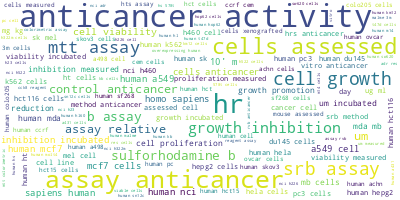

In [29]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(processed_data['descriptions_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [8]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [11]:
import gensim # open-source library for unsupervised topic modeling and NLP
from gensim.utils import simple_preprocess
import nltk # Natural Language Toolkit is a library to work with human language data

# Storing a list of stopwords
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') # Selecting english stopwords
stop_words.extend(['anticancer', 'activity']) # adding new stopwords

# Defining a function to convert our descriptions to word tokens and remove ponctuation
def sent_to_words(descriptions):
    i = 0
    for description in descriptions:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(description), deacc=True)) 
        
# Defining a function to remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [17]:
print(len(processed_data.descriptions_processed.tolist()))
print(len(processed_data.descriptions_processed.unique().tolist()))

37944
4379


In [19]:
data = processed_data.descriptions_processed.unique().tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

In [14]:
print(len(data_words)) #Showing our first description tokens

4379


In [21]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words

# Term Document Frequency
# Converts a collection of words to  a list of (word_id, word_frequency) 2-tuples.
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
from pprint import pprint
# number of topics
num_topics = 50
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=0)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(35,
  '0.093*"cells" + 0.092*"human" + 0.079*"assessed" + 0.073*"assay" + '
  '0.065*"cell" + 0.059*"hrs" + 0.047*"growth" + 0.039*"mtt" + '
  '0.035*"inhibition" + 0.023*"srb"'),
 (19,
  '0.072*"cells" + 0.063*"human" + 0.056*"assessed" + 0.036*"growth" + '
  '0.033*"mouse" + 0.030*"hrs" + 0.028*"kg" + 0.028*"mg" + 0.027*"inhibition" '
  '+ 0.025*"cell"'),
 (1,
  '0.075*"cells" + 0.067*"human" + 0.050*"assessed" + 0.049*"assay" + '
  '0.044*"cell" + 0.037*"growth" + 0.033*"hrs" + 0.031*"inhibition" + '
  '0.030*"mtt" + 0.023*"kg"'),
 (21,
  '0.091*"cells" + 0.089*"human" + 0.078*"assay" + 0.067*"hrs" + '
  '0.059*"assessed" + 0.051*"cell" + 0.043*"growth" + 0.038*"srb" + 0.033*"um" '
  '+ 0.031*"inhibition"'),
 (5,
  '0.090*"cells" + 0.084*"human" + 0.069*"assessed" + 0.066*"cell" + '
  '0.063*"assay" + 0.049*"hrs" + 0.048*"growth" + 0.045*"inhibition" + '
  '0.029*"mtt" + 0.022*"incubated"'),
 (11,
  '0.085*"cells" + 0.082*"human" + 0.069*"assay" + 0.063*"hrs" + '
  '0.061*"assesse

In [ ]:
# function for determining ideal number of topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [12]:
topics, probabilities = topic_modeling_on_assay_descriptions_w_bert(descriptions)

config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 193kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 23.1MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 123kB/s]
config.json: 100%|██████████| 612/612 [00:00<00:00, 1.05MB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:00<00:00, 229MB/s]
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 521kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.56MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.09MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 434kB/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just

TypeError: cannot unpack non-iterable NoneType object

In [1]:
print("topic_modeling_on_assay_descriptions" in dir())

False
